In [ ]:
import os
import spei as sp #spei package
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as scs
from joblib import Parallel, delayed
import multiprocessing
import mhm_dataprocessing as md
import geopandas as gpd
from tqdm import tqdm  # pip install tqdm
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rio
from itertools import product
import mhm_drought_funcs as mdf
from datetime import datetime
#mdates
import matplotlib.dates as mdates

#### Open datasets

In [3]:
src = r'D:/VUB/_data/mHM_EOBS'

#Data already clipped to domain boundaries
pet = xr.open_dataset(f'{src}/pet_UTMx.nc')
pre = xr.open_dataset(f'{src}/pre_UTMx.nc')
sMI = xr.open_dataset(f'{src}/SMI.nc')
spi_3_da = xr.open_dataset(f'{src}/spi_3_hpc.nc') #implemented in the HPC
spi_1_da = xr.open_dataset(f'{src}/spi_1_hpc.nc') #implemented in the HPC
spei_1_da = xr.open_dataset(f'{src}/spei_1.nc') #implemented in the HPC
spei_3_da = xr.open_dataset(f'{src}/spei_3.nc') #implemented in the HPC


drought_ADM = pd.read_csv(os.path.join(src, 'results_ADM.txt'), index_col=0, sep="\s+")

#outputs: drought clusters
dCluster = xr.open_dataset(f'{src}/DCluster.nc')
sMI = xr.open_dataset(f'{src}/SMI.nc')
mask = xr.open_dataset(f'{src}/BE_SMI_mask.nc')

#BE shapefile
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be_joined_epsg_32631.shp")

#### Clip to model domain and simulation period

In [4]:
#clip the Datasets to BE boundary
pet = md.clip_to_region(be_shp, pet)
pre = md.clip_to_region(be_shp, pre)

#slide data to start from 1970
pet = pet.sel(time=slice('1970-01-01', None))
pre = pre.sel(time=slice('1970-01-01', None))

#mask areas with constant values using data variance
pet = pet.where(pet.pet.var(dim='time') > 0.001, drop=False)
pre = pre.where(pre.pre.var(dim='time') > 0.001, drop=False)

#compute water balance (precipitatione excess) for spei
p_excess = pre.pre - pet.pet

In [5]:
#p_excess to xr dataset
p_excess = p_excess.to_dataset(name='p_excess')
#p_excess.to_netcdf(f'{src}/p_excess_BE_UTMx.nc')
# pre.to_netcdf(f'{src}/pre_BE_UTMx.nc')

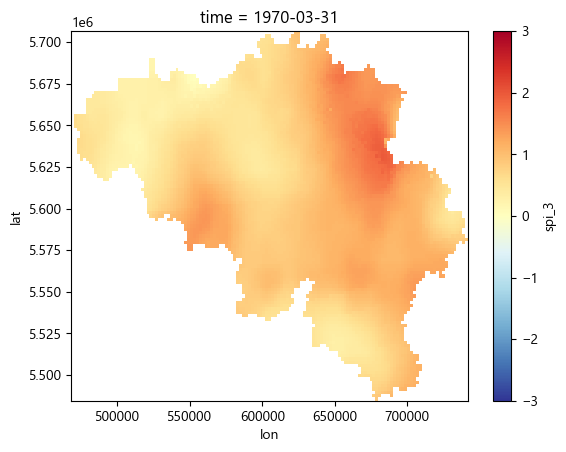

In [6]:
spi_3_da['spi_3'].isel(time=0).plot(cmap='RdYlBu_r', vmin=-3, vmax=3)

#### Clip dCluster to match extent of meteo datasets

In [7]:
#clip dCLuster using pre map
dCluster = dCluster.sel(lat=slice(pre.lat.max(), pre.lat.min()),
                        lon=slice(pre.lon.min(), pre.lon.max()))

#### GRid Cell SPI and SPEI
Run only once. The datasets will be saved as netcdf which can then imported together with the other input files.

In [8]:
# # Compute SPI for different timescales
# spi_1 = mdf.compute_SPI(pre, 'pre', 30)  # SPI-1
# #export the SPI-1 to netcdf
# spi_1.to_netcdf(f'{src}/spi_1.nc')

# # Compute SPEI for the given timescale
# spei_1 = mdf.compute_SPEI(p_excess, 'p_excess', 30)  # SPEI-1
# # Export the SPEI-1 to netcdf
# spei_1.to_netcdf(f'{src}/spei_1.nc')

#### Validate spatial datasets with timeseries

In [9]:
#3 month p_excess accumulation
timescale = 30
p_excess_accum = p_excess.rolling(time=timescale).sum()
pre_accum = pre.rolling(time=timescale).sum()

In [10]:
lat = 5589595.563692  # Example latitude in UTM
lon = 705128.602119  # Example longitude in UTM

p_excess_tx = p_excess_accum['p_excess'].sel(lat=lat, lon=lon, method='nearest').to_series().dropna()
precip_tx = pre_accum.pre.sel(lat=lat, lon=lon, method='nearest').to_series().dropna()

spi_3 = sp.spi(precip_tx, dist=scs.gamma, fit_freq="ME")
spi_3_d = sp.spi(precip_tx, dist=scs.gamma, fit_freq="ME")
spei_3 = sp.spei(p_excess_tx, fit_freq="ME")

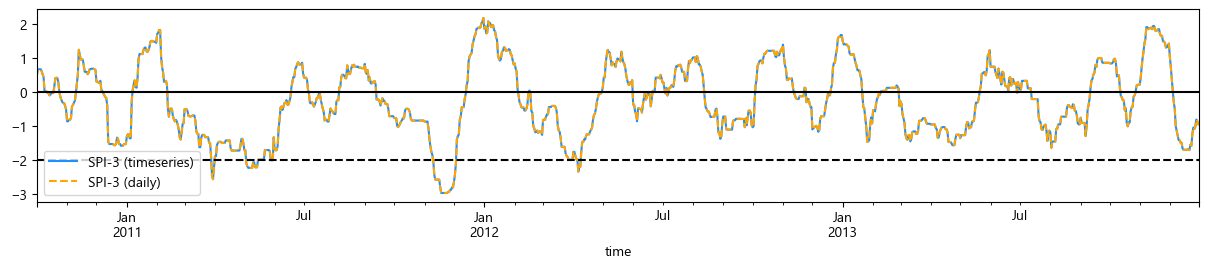

In [11]:
fig, ax = plt.subplots(figsize=(15, 2.5))
startwindow = '2010-10-01'
endwindow='2013-12-31'

#spei_da.sel(lat=lat, lon=lon, method='nearest').to_dataframe().drop(columns=['lat', 'lon'])[startwindow:endwindow].plot(ax=ax, color='blue', label='SPEI-3 (calculated)')
#spei_3[startwindow:endwindow].plot(ax=ax, color='red', ls='--', label='SPEI-3 (calculated)')

# spi_3_da.sel(lat=lat, lon=lon, method='nearest').to_dataframe().drop(columns=['lat', 'lon'])[startwindow:endwindow].plot(ax=ax, c='r')
spi_3[startwindow:endwindow].plot(ax=ax, color='dodgerblue', label='SPI-3 (timeseries)')
spi_3_d[startwindow:endwindow].plot(ax=ax, color='orange', label='SPI-3 (daily)', ls='--')

plt.axhline(-2, color='black', ls='--')
plt.axhline(0, color='black', ls='-')
plt.legend()

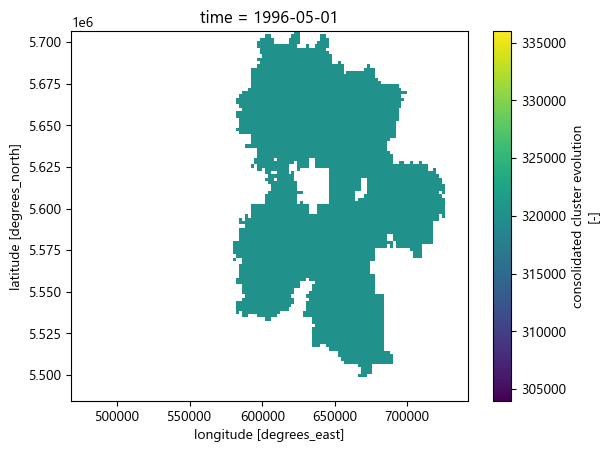

In [12]:
dCluster.sel(time=slice('1995-08-01', '1996-08-28'))['mDC'][9].plot()

#### Compare SMI and SPEI

In [25]:
#cluster_IDs for major droughts
base_date = datetime(1970, 1, 1) # simulation starts from 1970-01-01, which is mStart=1, so we use 1969-12-31 as the base date

drought_ADM = mdf.assign_date_ADM(drought_ADM, base_date)

In [104]:
#top 3 drought events earlier than 2022
drought_ADM_top = drought_ADM.nlargest(4, 'TDM').sort_values(by='TDM', ascending=False)
drought_ADM_top=drought_ADM_top[drought_ADM_top['c_Id'] != 638001] # Remove the last row with c_Id 638001 (2022 drought)

In [105]:
drought_ADM_top= drought_ADM.nlargest(4, 'TDM').sort_values(by='mStart', ascending=True)
drought_ADM_top

,c_Id,mStart,mEnd,aDD,aDA,TDM,start_month,end_month
i,,,,,,,,
20,85003,70,85,10.02164,0.62635,8934.97340,1975-10-01,1977-01-01
107,575001,561,575,9.60832,0.64055,9193.14235,2016-09-01,2017-11-01
109,590001,581,590,7.31791,0.73179,7120.87778,2018-05-01,2019-02-01
119,638001,627,638,8.39090,0.69924,7870.74532,2022-03-01,2023-02-01


In [ ]:
top_drought_clusters = dCluster.where(dCluster.mDC.isin(drought_ADM_top['c_Id']))

masked_clusters = top_drought_clusters.where(pet['pet'][0]>-1)

In [55]:
#extract each cluster and plot
cID_575001 = masked_clusters.where(masked_clusters.mDC == 575001).dropna(dim='time', how='all')

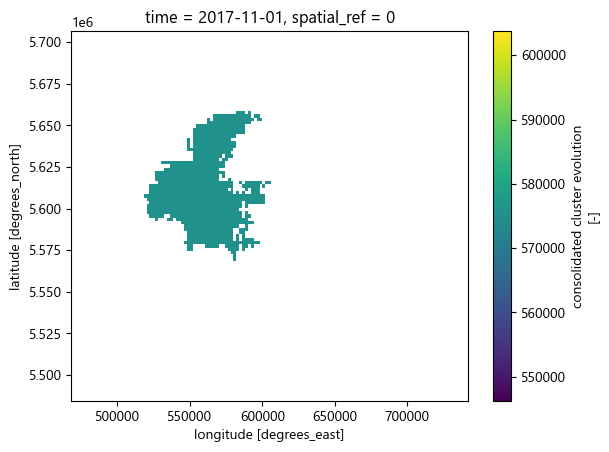

In [69]:
cID_575001['mDC'][14].plot()

### Plot comparison of SMI and SPI

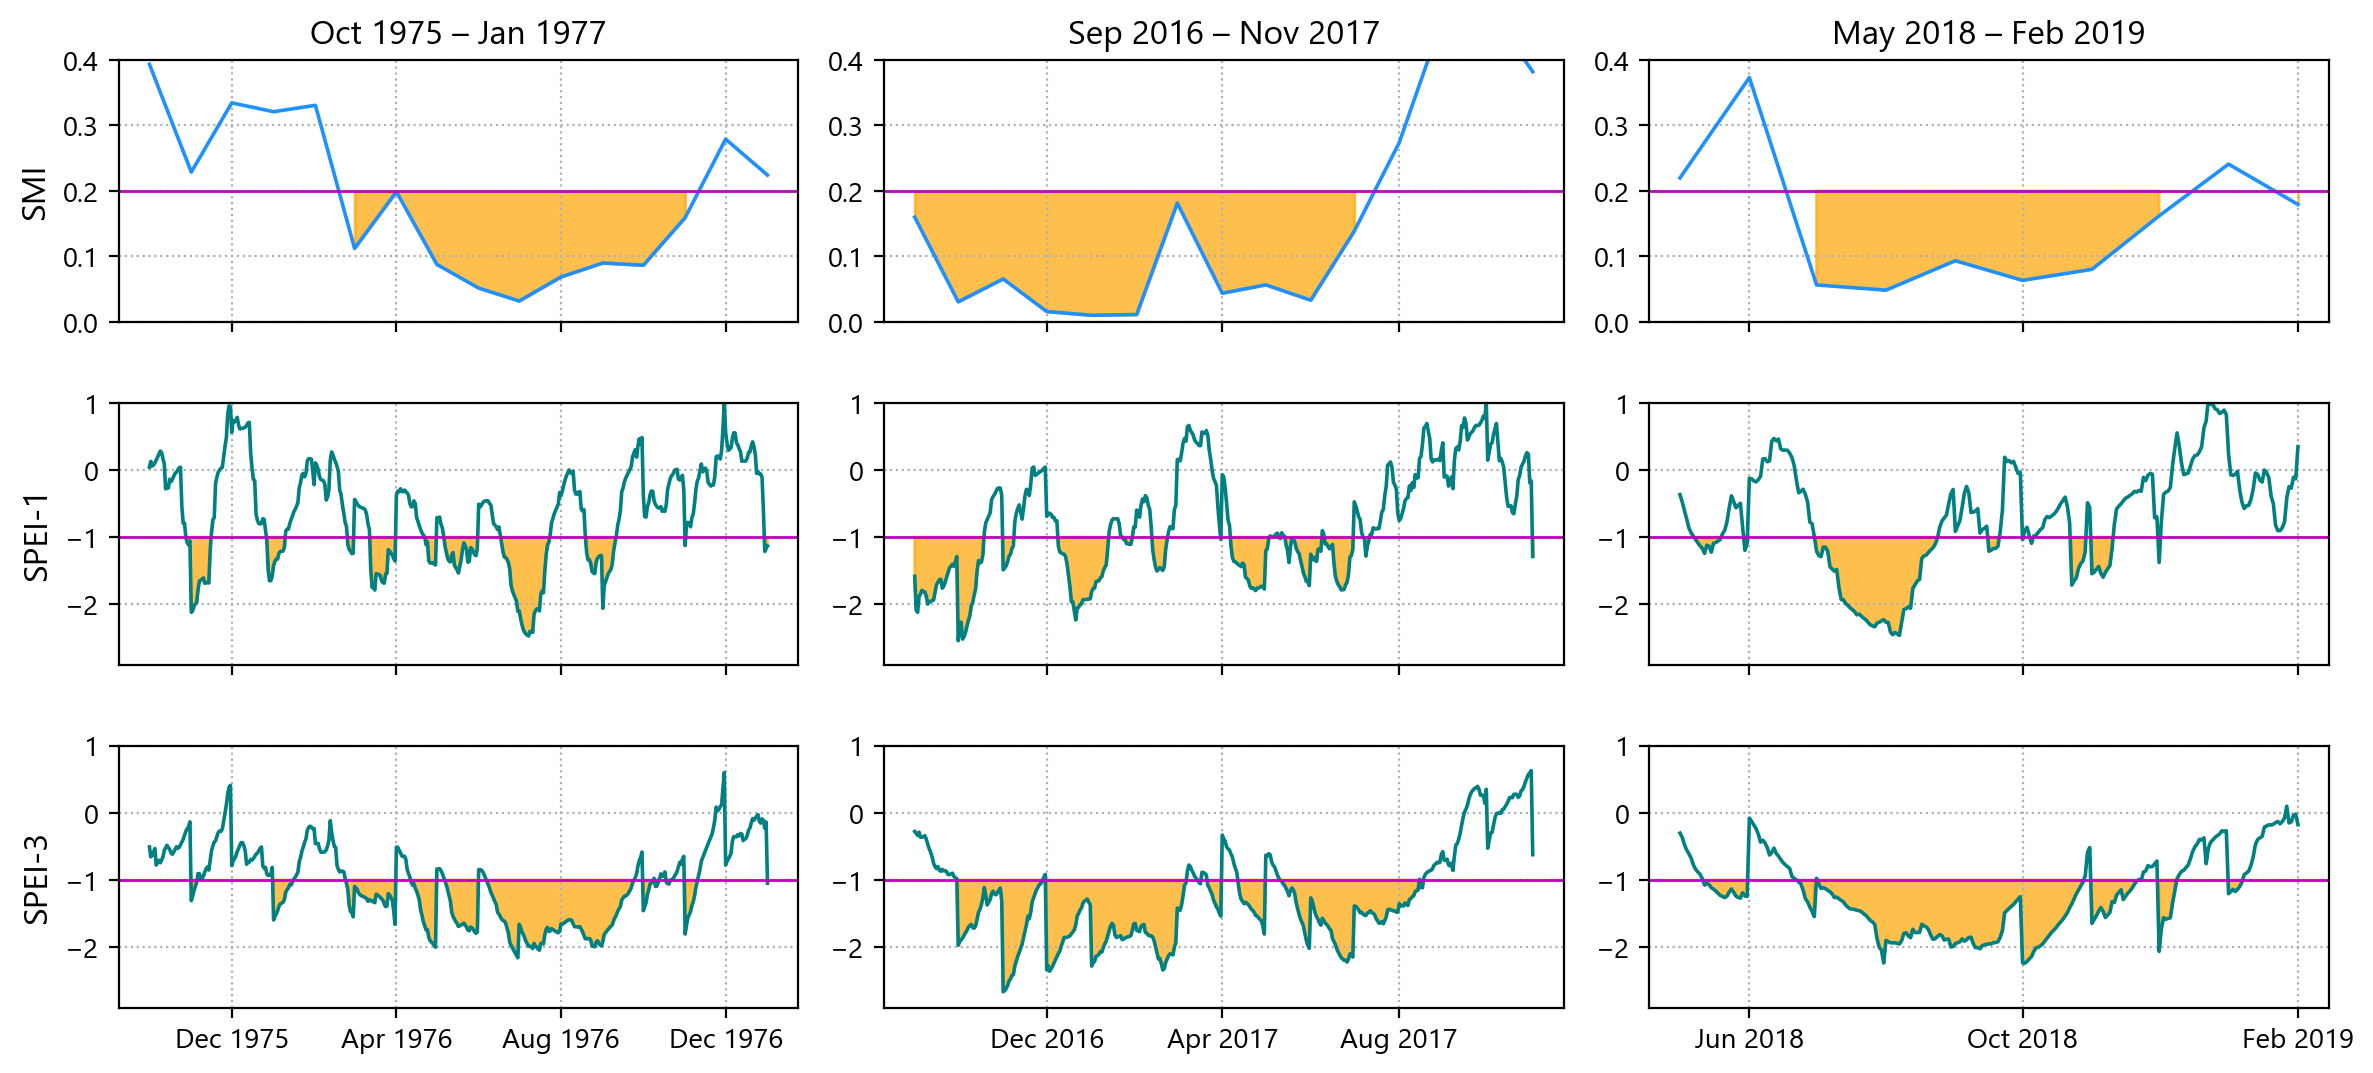

In [119]:
n_events = len(drought_ADM_top.head(3))
fig, axes = plt.subplots(3, n_events, figsize=(4.0 * n_events, 5.5), sharex='col', dpi=200)

# Handle shape in case of single event
if n_events == 1:
    axes = axes[:, np.newaxis]

lat_min, lat_max, lon_min, lon_max = 5525000, 5600000, 500000, 700000

for col, row in enumerate(drought_ADM_top.head(3).itertuples()):

    start_date = row.start_month
    end_date = row.end_month

    # Extract time series for the drought region
    smi_ts = sMI['SMI'].sel(time=slice(start_date, end_date),
                            lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max)
               ).mean(dim=['lat', 'lon']).to_series().rolling(window=1).mean()

    spei1_ts = spei_1_da['spei_1'].sel(time=slice(start_date, end_date),
                            lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max)
               ).mean(dim=['lat', 'lon']).to_series().rolling(window=1).mean()

    spei3_ts = spei_3_da['spei_3'].sel(time=slice(start_date, end_date),
                            lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max)
               ).mean(dim=['lat', 'lon']).to_series().rolling(window=1).mean()

    # --- Plot SMI ---
    ax_smi = axes[0, col]
    ax_smi.plot(smi_ts, color='dodgerblue', label='SMI', linewidth=1.3)
    ax_smi.fill_between(smi_ts.index, smi_ts, 0.2, where=(smi_ts <= 0.2), color='orange', alpha=0.7)
    ax_smi.axhline(0.2, color='m', lw=1.0)
    ax_smi.set_ylim(0,0.4)
    if col == 0:
        ax_smi.set_ylabel('SMI', fontsize=12)
    ax_smi.set_title(f'{start_date.strftime("%b %Y")} – {end_date.strftime("%b %Y")}')
    ax_smi.grid(True, linestyle=':')

    # --- Plot SPEI-1 ---
    ax_spei1 = axes[1, col]
    ax_spei1.plot(spei1_ts, color='teal', linewidth=1.3)
    ax_spei1.fill_between(spei1_ts.index, spei1_ts, -1.0, where=(spei1_ts < -1.0), color='orange', alpha=0.7)
    ax_spei1.axhline(-1, color='m', lw=1.0)
    ax_spei1.set_ylim(-2.9,1.0)
    if col == 0:
        ax_spei1.set_ylabel('SPEI-1', fontsize=12)
    ax_spei1.grid(True, linestyle=':')

    # --- Plot SPEI-3 ---
    ax_spei3 = axes[2, col]
    ax_spei3.plot(spei3_ts, color='teal', linewidth=1.3)
    ax_spei3.fill_between(spei3_ts.index, spei3_ts, -1.0, where=(spei3_ts <= -1), color='orange', alpha=0.7)
    ax_spei3.axhline(-1, color='m', lw=1.0)
    ax_spei3.set_ylim(-2.9,1.0)
 
    if col == 0:
        ax_spei3.set_ylabel('SPEI-3', fontsize=12)
    ax_spei3.grid(True, linestyle=':')
    ax_spei3.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax_spei3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Final formatting
plt.tight_layout(h_pad=2)
#plt.suptitle("SMI and SPEI Comparisons During Major Drought Events", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.93)
plt.show()

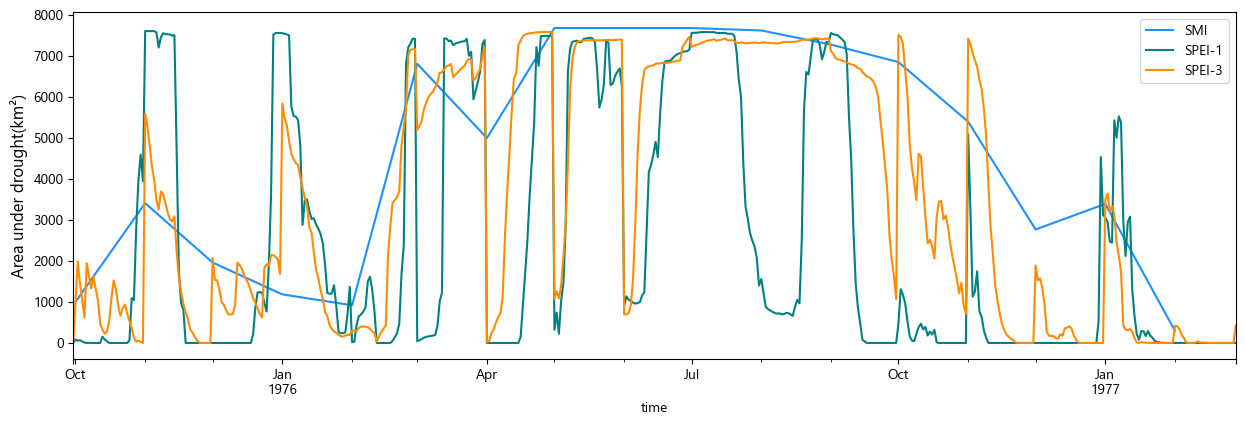

In [109]:
fig, axes = plt.subplots(figsize=(15, 4.5))


plt.subplots_adjust(hspace=0.2)


start_time = '1975-09-30' 	
end_time = '1977-02-28'

tx_sMI=sMI.sel(time=slice(start_time, end_time))
tx_sPEI_1 = spei_1_da.sel(time=slice(start_time, end_time))
tx_sPEI_3 = spei_3_da.sel(time=slice(start_time, end_time))

#sum up pixels below 0.2 SMI and spei < 1.0
area_smi=tx_sMI['SMI'].where(tx_sMI['SMI']<0.2).notnull().sum(dim=['lat', 'lon'])
area_spei_1=tx_sPEI_1['spei_1'].where(tx_sPEI_1['spei_1']<-1.0).notnull().sum(dim=['lat', 'lon'])
area_spei_3=tx_sPEI_3['spei_3'].where(tx_sPEI_3['spei_3']<-1.0).notnull().sum(dim=['lat', 'lon'])

#plot all in one figure
area_smi.to_series().plot(color='dodgerblue', label='SMI', ax=axes)
area_spei_1.to_series().plot(color='teal', label='SPEI-1', ax=axes)
area_spei_3.to_series().plot(color='darkorange', label='SPEI-3', ax=axes)
axes.set_ylabel('Area under drought(km²)', fontsize=12)

axes.legend()